
# Factoring 15 with Shor's Algorithm



## Introduction

The integer factorization problem [[1](#IntegerFactor)] is a famous problem in number theory: given a number $N$ which is composite, find its prime factors. The importance of the problem stems from the fact that no efficient (polynomial-time, in the number of bits needed to represent $N$) classical algorithm is known for it to this day, and much of modern day cryptography relies on this fact. In 1994, Peter Shor came up with an efficient _quantum_ algorithm for the problem [[2](#Shor94)] - providing one of the first concrete pieces of evidence for the power of quantum computers.

### Shor's Algorithm

Shor's algorithm consists of a classical part and a quantum subroutine. The steps of the algorithm for factoring an input number $N$, summarized from [[3](#ShorSteps)], are as follows:

1. Pick a random number $1 < a < N$ that is co-prime with $N$. Co-primality can be checked by computing the GCD (greatest common divisor) of $a$ and $N$ - if it is 1 then we have found a co-prime $a$, otherwise we have found a non-trivial factor of $N$ and we are done.
2. Find the period $r$ of the following function, using the quantum period finding algorithm (described in [[4](#PeriodFinding)]): $$f(x) = a^x \mod N$$
3. If $r$ is odd or $a^{r/2} = -1 \mod N$, return to step 1 (this event can be shown to happen with probability at most $1/2$).
4. Otherwise, $\gcd(a^{r/2} \pm 1, N)$ are both factors of $N$, and computing one of them yields the required result.

In this demo, we will factor the number $N=15$ using Shor's algorithm, by applying the quantum subroutine (step 2) with $a=7$. This particular $a$ is chosen since it is co-prime with 15 and satisfies the conditions of step 3, providing us with a high probability of finding a factor of $N$.


## Building the quantum period finding circuit

We begin by declaring the number of qubits in the upper (counting) register the quantum subroutine uses. In our case, $N = 15$, and according to the algorithm the upper register must contain $q = \log(Q)$ qubits for $Q$ such that $N^2 \le Q < 2N^2$, namely $225 < Q < 450$, and therefore $q = 8$. In addition, the second register should be large enough to encode 15, hence:

In [1]:
import numpy as np

N = 15

num_counting_qubits = int(np.ceil(np.log2(N**2)))
num_auxilliary_qubits = int(np.ceil(np.log2(N)))

We will implement a Phase Estimation [[5](#PhaseEstimation)] circuit. Each element in the circuit is a controlled operation of: $$|x\rangle \rightarrow |x\cdot a^{2^i}\mod N \rangle $$ where $a < N$ is a number such that $\gcd(a, N)=1$. For this demonstration we picked $a=7$. $i$ is the index of the control qubit, located in the upper register.

It is quiet involved to implement these unitaries, so for this demo we will make a shortcut, and compute exactly the unitary matrix that implements the computation (which in the general case is not applicable as this pre-processing is exponential). We will do so by calculating the modular-multiplication by $a$ matrix, then using its powers.

The function `unitary` is used for decomposing the unitary matrix into quantum gates.

In [2]:
from classiq import (
    Output,
    QArray,
    QBit,
    QParam,
    X,
    allocate,
    control,
    create_model,
    hadamard_transform,
    invert,
    power,
    qft,
    qfunc,
    repeat,
    unitary,
)


def get_modular_multiplication_matrix():
    # fmt: off
    swap = np.array(
        [
            [1, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1]
        ],
        dtype=complex
    )
    # fmt: on
    swap32 = np.kron(np.identity(4), swap)
    swap21 = np.kron(np.kron(np.identity(2), swap), np.identity(2))
    swap10 = np.kron(swap, np.identity(4))
    x = np.array([[0, 1], [1, 0]])
    x_all = np.kron(np.kron(x, x), np.kron(x, x))
    u = x_all @ swap10 @ swap21 @ swap32
    return u


MODULAR_MUL_UNITARY = get_modular_multiplication_matrix().real.tolist()


@qfunc
def modular_exponentiation(
    exponent: QParam[int], target: QArray[QBit, num_auxilliary_qubits]
) -> None:
    power(2**exponent, lambda: unitary(elements=MODULAR_MUL_UNITARY, target=target))

### Building the complete circuit

At the first layer of the quantum circuit, we prepare the equal superposition state in the top (counting) register, and prepare the $|1\rangle$ state in the bottom (auxiliary) register.

We then apply the second layer of the circuit, which consists of the controlled $U^{2^i}$ gates. 
Lastly, we apply an inverse QFT on the counting register, to get the period.

In [3]:
@qfunc
def period_finding(
    qv_counting: Output[QArray[QBit, num_counting_qubits]],
    qv_auxilliary: Output[QArray[QBit, num_auxilliary_qubits]],
) -> None:
    # start with a hadamard transform in the counting register
    allocate(num_counting_qubits, qv_counting)
    hadamard_transform(qv_counting)

    # Prepare the |1> state on the lower register
    allocate(num_auxilliary_qubits, qv_auxilliary)
    X(qv_auxilliary[0])

    # Apply the contolled modular-exponentiations using each of the counting qubits
    repeat(
        count=num_auxilliary_qubits,
        iteration=lambda index: control(
            operand=lambda: modular_exponentiation(index, qv_auxilliary),
            ctrl=qv_counting[index],
        ),
    )  # ! not working with qv[a:]

    # Lastly, apply an inverse QFT
    invert(lambda: qft(qv_counting))

### Quantum entry point
In order to synthesize the circuit, we define a quantum `main` function. As are we only interested in the output of the counting register, we only define it in the signature of the function.

Next, we translate it to qmod using the `create_model`.

In [4]:
@qfunc
def main(qv_counting: Output[QArray[QBit, num_counting_qubits]]) -> None:
    qv_auxilliary = QArray("qv_auxilliary")
    period_finding(qv_counting, qv_auxilliary)


qmod = create_model(main)

In [5]:
from classiq import write_qmod

write_qmod(qmod, "shor")

We now send the model to the synthesis engine, taking a few seconds:

In [6]:
from classiq import synthesize

qprog = synthesize(qmod)

We can now view the circuit and its depth:

In [7]:
from classiq import show

show(qprog)

Opening: https://platform.classiq.io/circuit/727fcbe0-e793-44b4-8080-1cdd94d57e43?version=0.38.0.dev42%2Bfd36e2c41c


## Executing the circuit

Now, we turn to executing the circuit above, using the simulator:

In [8]:
from classiq import execute

results = execute(qprog).result()
res = results[0].value

In [9]:
import collections

hist_counting_qubits = collections.defaultdict(int)
for key, value in res.counts.items():
    hist_counting_qubits[key] += value

Plotting the result:

<BarContainer object of 4 artists>

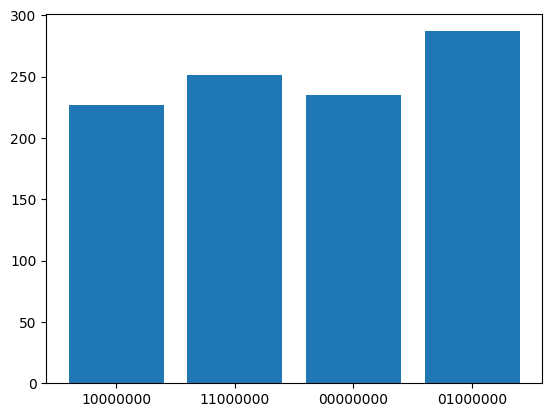

In [10]:
import matplotlib.pyplot as plt

plt.bar(hist_counting_qubits.keys(), hist_counting_qubits.values())

We obtained 4 results $y$ from the circuit, each with probability roughly $1/4$: $0, 64, 128$ and $192$. Dividing by $Q = 256$ we obtain 4 reduced fractions: $0, 1/4, 1/2$ and $3/4$, with two of them having the correct period $r=4$ in the denominator. With this period, we can compute the factors of $N = 15$: $\gcd(a^{r/2} \pm 1, N) = \gcd(7^2 \pm 1, 15) = 3, 5$.

## References

<a id='IntegerFactor'>[1]</a>: [Integer Factorization (Wikipedia)](https://en.wikipedia.org/wiki/Integer_factorization)

<a id='Shor94'>[2]</a>: [Shor, Peter W. "Algorithms for quantum computation: discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. Ieee, 1994.](https://ieeexplore.ieee.org/abstract/document/365700)

<a id='ShorSteps'>[3]</a>: [Shor's Algorithm Procedure (Wikipedia)](https://en.wikipedia.org/wiki/Shor%27s_algorithm#Procedure)

<a id='PeriodFinding'>[4]</a>: [Quantum Period Finding (Wikipedia)](https://en.wikipedia.org/wiki/Shor%27s_algorithm#Quantum_part:_period-finding_subroutine)

<a id='PhaseEstimation'>[5]</a>: [Quantum Phase Estimation (Wikipedia)](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm)
